In [1]:
import numpy as np
import scipy.fftpack
from scipy import ndimage
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import os

In [2]:
data=pd.read_table('datos.txt')
nom_reg = '604'
nom_lin = 'Halpha'
pc=4.16

In [3]:
data.describe()

,X,Y,RV
count,330.000000,330.000000,330.000000
mean,107.280000,9.390000,-275.757688
std,12.788265,6.260324,9.697986
min,85.824000,0.000000,-296.649181
25%,96.552000,4.000000,-282.613847
50%,107.280000,9.000000,-276.070115
75%,118.008000,15.000000,-270.394313
max,128.736000,19.600000,-231.143341


(0.0, 33.0, 0.0, 10.0)

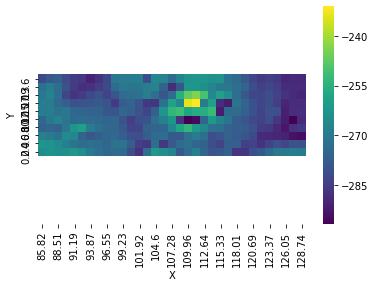

In [4]:
data_2=(data.round(2)).pivot(index='Y', columns='X', values='RV')
sns.heatmap(data_2, cmap="viridis")
plt.gca().invert_yaxis()
plt.axis('equal')

In [34]:
FT2a=scipy.fftpack.fft2(data_2)
FT2 = scipy.fftpack.fftshift(FT2a)
powr2 = np.abs(FT2)

(0.0, 33.0, 0.0, 10.0)

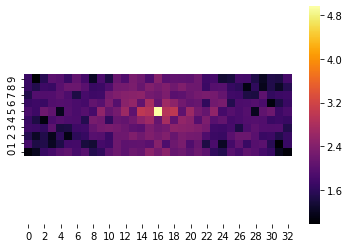

In [38]:
sns.heatmap(np.log10(powr2), cmap="inferno")
plt.gca().invert_yaxis()
plt.axis('equal')

In [11]:
#plt.contourf(np.log10(powr2), cmap="inferno")
#plt.gca().invert_yaxis()
#plt.axis('equal')

PSD1D

In [8]:

h  = powr2.shape[0]
w  = powr2.shape[1]
wc = w//2
hc = h//2

# create an array of integer radial distances from the center
Y, X = np.ogrid[0:h, 0:w]
r    = np.hypot(X - wc, Y - hc).astype(np.int)

# SUM all psd2D pixels with label 'r' for 0<=r<=wc
# NOTE: this will miss power contributions in 'corners' r>wc
psd1D = ndimage.sum(powr2, r, index=np.arange(0, wc))


In [31]:
len(r[:][2])

33

In [20]:
ndimage.sum(powr2, r, index=[7,7])

array([2679.5785896, 2679.5785896])

In [22]:
len(psd1D)

16

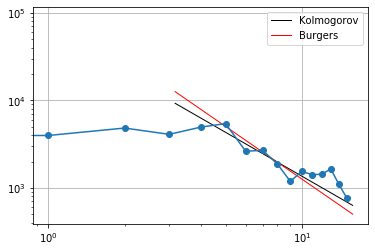

In [10]:
sgrid = np.logspace(0.5, 1.2)
plt.plot(sgrid, (10**4.8)*sgrid**(-5/3), color="k", lw=1, label="Kolmogorov")
plt.plot(sgrid, (10**5.1)*sgrid**(-2), color="r", lw=1, label="Burgers")
plt.loglog(psd1D,'o-')
plt.legend()
#plt.xlim(2, 20)
#plt.ylim(400,16000)
plt.grid()